Loading dataset...
Extracting features...
X:  2082  y:  2082
Training model...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 285s 998ms/step - accuracy: 0.5985 - loss: 1.2936 - precision: 0.5985 - recall: 0.5985 - val_accuracy: 0.4693 - val_loss: 1.8931 - val_precision: 0.4693 - val_recall: 0.4693
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 175s 932ms/step - accuracy: 0.7341 - loss: 1.0302 - precision: 0.7341 - recall: 0.7341 - val_accuracy: 0.4693 - val_loss: 1.3320 - val_precision: 0.4693 - val_recall: 0.4693
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 184s 980ms/step - accuracy: 0.7905 - loss: 0.8037 - precision: 0.7905 - recall: 0.7905 - val_accuracy: 0.6320 - val_loss: 1.4357 - val_precision: 0.6320 - val_recall: 0.6320
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 183s 971ms/step - accuracy: 0.8326 - loss: 0.6440 - precision: 0.8326 - recall: 0.8326 - val_accuracy: 0.7733 - val_loss: 0.6873 - val_precision: 0.7733 - val_recall: 0.7733
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 185s 985ms/step - accurac

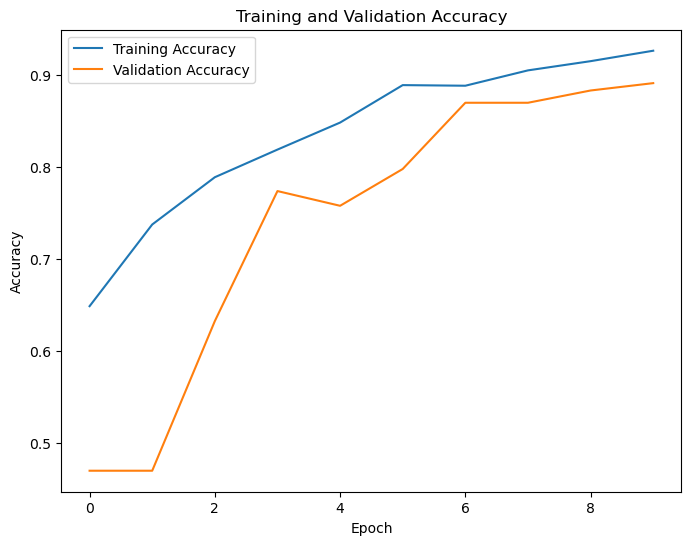

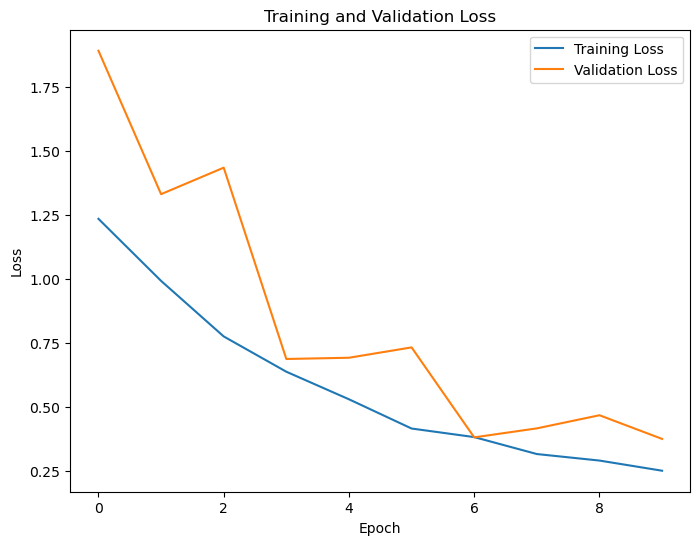

Validating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
Validation Precision: 0.90
Validation Accuracy: 0.89
Validation Recall: 0.86
Testing model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 631ms/step


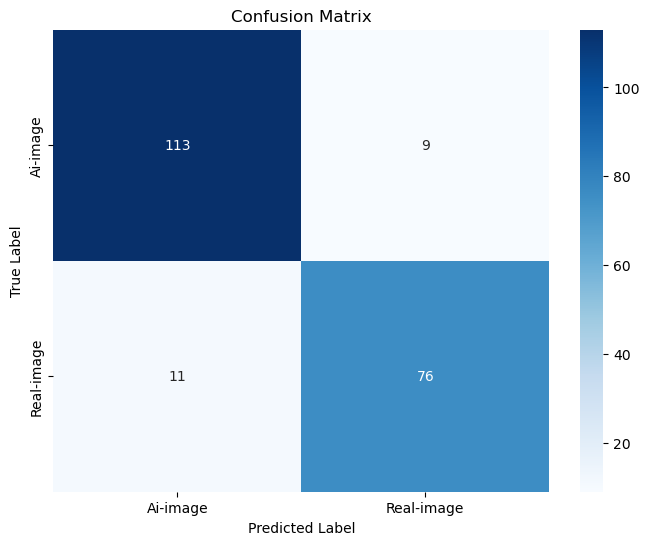

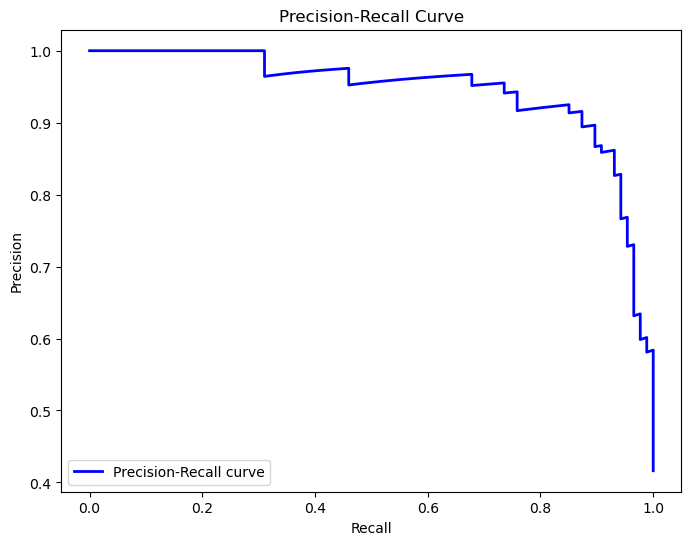

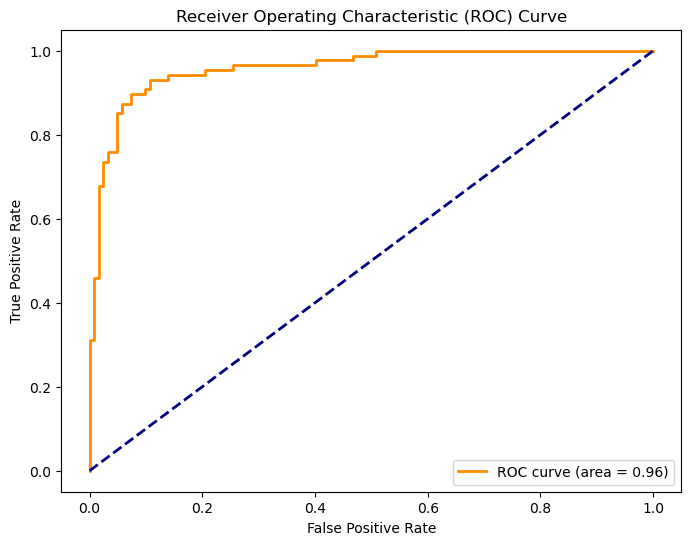

Test Accuracy: 0.90
Test Recall: 1.00
Test Precision: 0.42


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
# from PIL import Image


def extract_feature(image):
    image_data = cv2.imread(image)
    img_gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    sift_keypoints = sift.detect(image_data, None)
    sift_g_keypoints = sift.detect(img_gray, None)
    img_keys = cv2.drawKeypoints(image_data, sift_keypoints, None)
    img_gray_keys = cv2.drawKeypoints(img_gray, sift_g_keypoints, None)
    img_keys = cv2.resize(img_keys, (224, 224))
    img_gray_keys = cv2.resize(img_gray_keys, (224, 224))
    img_keys = img_keys / 255.0
    img_gray_keys = img_gray_keys / 255.0
    tensor_img = tf.convert_to_tensor(img_keys)
    tensor_img_gray = tf.convert_to_tensor(img_gray_keys)
    return tensor_img, tensor_img_gray


def load_dataset(data_dir):
    print('Loading dataset...')
    X = []
    y = []
    print('Extracting features...')
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image_tensor, gray_image_tensor = extract_feature(image_path)
            X.append(image_tensor)
            X.append(gray_image_tensor)
            y.append(label)
            y.append(label)
    return np.array(X), np.array(y)


def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    return f1_score(y_true, y_pred)


def train_model(X_train, y_train, X_val, y_val):
    print("Training model...")
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    
    adam_optimizer = Adam(learning_rate=0.001)
    
    output = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
    # model.fit(X_train, to_categorical(y_train), validation_data=(X_val, to_categorical(y_val)), epochs=60, batch_size=32)
    
    history = model.fit(X_train, to_categorical(y_train), validation_data=(X_val, to_categorical(y_val)), epochs=10, batch_size=8)
    
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model, history


def validate_model(model, X_val, y_val):
    print("Validating model...")
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    precision = precision_score(y_val, y_pred_classes, zero_division=0)
    accuracy = accuracy_score(y_val, y_pred_classes)
    recall = recall_score(y_val, y_pred_classes)
    return precision, accuracy, recall

def test_model(model, X_test, y_test):
    print("Testing model...")
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    precision = precision_score(y_test, y_pred_classes, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    
    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return precision, accuracy, recall


# data_dir = r'C:\Users\adepojuh\Documents\project\Implementation\Dataset'
data_dir = r'C:\Users\adepojuh\Documents\project\ai_and _real'
X, y = load_dataset(data_dir)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print("X: ", len(X), ' y: ', len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model, history = train_model(X_train, y_train, X_val, y_val)
val_precision, val_accuracy, val_recall = validate_model(model, X_val, y_val)
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Recall: {val_recall:.2f}")

test_precision, test_accuracy, test_recall = test_model(model, X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Recall: {test_recall[0]:.2f}")
print(f"Test Precision: {test_precision[0]:.2f}") 


In [15]:
print(model)

<Functional name=functional_13, built=True>
